In [343]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt

os.chdir("/Users/jacobrichards/Desktop/DS_DA_Projects/3-90+_DaysPastDue/Data_Files")

train = pd.read_csv("FITB_train.csv", na_values=["", "NA"])

test = pd.read_csv("FITB_test.csv", na_values=["", "NA"])

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

remove upper and lower 1% of feature 3 for train but not test 

In [344]:
lower_bound = train['feature_3'].quantile(0.01)
upper_bound = train['feature_3'].quantile(0.99)

train = train[(train['feature_3'] >= lower_bound) & (train['feature_3'] <= upper_bound)]

replace na with median value for both

In [345]:
train_median = train['feature_3'].median()
train['feature_3'].fillna(train_median, inplace=True)

test_median = test['feature_3'].median()
test['feature_3'].fillna(test_median, inplace=True)

replace na of feature 2 with forward fill and backward fill 

In [346]:
train['date'] = pd.to_datetime(train['date']).dt.year
test['date'] = pd.to_datetime(test['date']).dt.year

def impute_feature_2(df):
    df = df.sort_values(by=['id', 'date'])
    df['feature_2'] = df['feature_2'].fillna(method='ffill')
    df['feature_2'] = df['feature_2'].fillna(method='bfill')
    return df

train = train.groupby('id', group_keys=False).apply(impute_feature_2)
test = test.groupby('id', group_keys=False).apply(impute_feature_2)

replace y with 1 if 90+DPD and 0 if active 

In [347]:
train['y'] = train['y'].apply(lambda x: 1 if x == "90+DPD" else 0 if x == "active" else x)
test['y'] = test['y'].apply(lambda x: 1 if x == "90+DPD" else 0 if x == "active" else x)

Standardize features

In [348]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train[['feature_1', 'feature_2', 'feature_3', 'feature_4']] = scaler.fit_transform(train[['feature_1', 'feature_2', 'feature_3', 'feature_4']])
test[['feature_1', 'feature_2', 'feature_3', 'feature_4']] = scaler.transform(test[['feature_1', 'feature_2', 'feature_3', 'feature_4']])

Logistic Regression Model 

produce interaction terms (once significant interactions were found in the EDA)

In [349]:
train['feature_1_x_feature_2'] = train['feature_1'] * train['feature_2']
test['feature_1_x_feature_2'] = test['feature_1'] * test['feature_2']
train['feature_1_x_feature_3'] = train['feature_1'] * train['feature_3']
test['feature_1_x_feature_3'] = test['feature_1'] * test['feature_3']
train['feature_2_x_feature_3'] = train['feature_2'] * train['feature_3']
test['feature_2_x_feature_3'] = test['feature_2'] * test['feature_3']
train['feature_2_x_feature_4'] = train['feature_2'] * train['feature_4']
test['feature_2_x_feature_4'] = test['feature_2'] * test['feature_4']
train['feature_3_x_feature_4'] = train['feature_3'] * train['feature_4']
test['feature_3_x_feature_4'] = test['feature_3'] * test['feature_4']

standardizing the interaction terms made it worse, probably because they're not normally distributed so the z-scores would be meaningless

model with interaction terms 

In [350]:
from sklearn.linear_model import LogisticRegression
import numpy as np
X_train = train[['feature_1', 'feature_2', 'feature_3', 'feature_4',
                 'feature_1_x_feature_2', 'feature_1_x_feature_3',
                 'feature_2_x_feature_3', 'feature_2_x_feature_4',
                 'feature_3_x_feature_4']]
y_train = train['y']

model = LogisticRegression(fit_intercept=True)
model.fit(X_train, y_train);

ROC Curve 

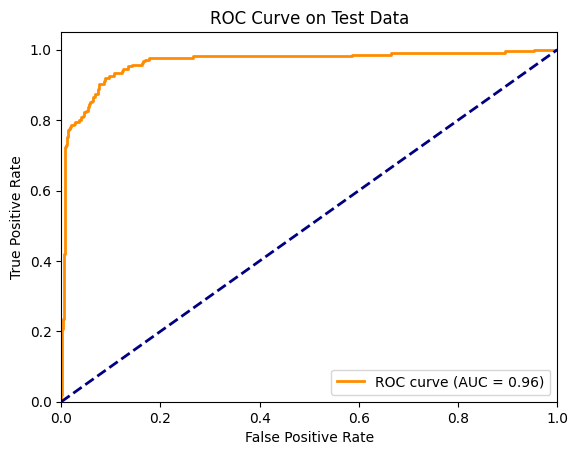

In [351]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

X_test = test[['feature_1', 'feature_2', 'feature_3', 'feature_4',
               'feature_1_x_feature_2', 'feature_1_x_feature_3',
               'feature_2_x_feature_3', 'feature_2_x_feature_4',
               'feature_3_x_feature_4']]
y_test = test['y']
y_pred_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Test Data')
plt.legend(loc="lower right")
plt.show()

optimal threshold 

In [352]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
fnr = 1 - tpr
optimal_idx = np.argmin(np.abs(fpr - fnr))
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold: {optimal_threshold:.3f}")

Optimal threshold: 0.307


In [353]:
from sklearn.metrics import confusion_matrix, recall_score

y_pred = (y_pred_proba >= optimal_threshold).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print(f"\nRecall at optimal threshold: {recall:.3f}")

Confusion Matrix:
[[771  74]
 [ 19 195]]

Recall at optimal threshold: 0.911


# Probability - Log(ods) - Observed Probability curves of predictors 

Optimization terminated successfully.
         Current function value: 0.393480
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.393480
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.393480
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.393480
         Iterations 8


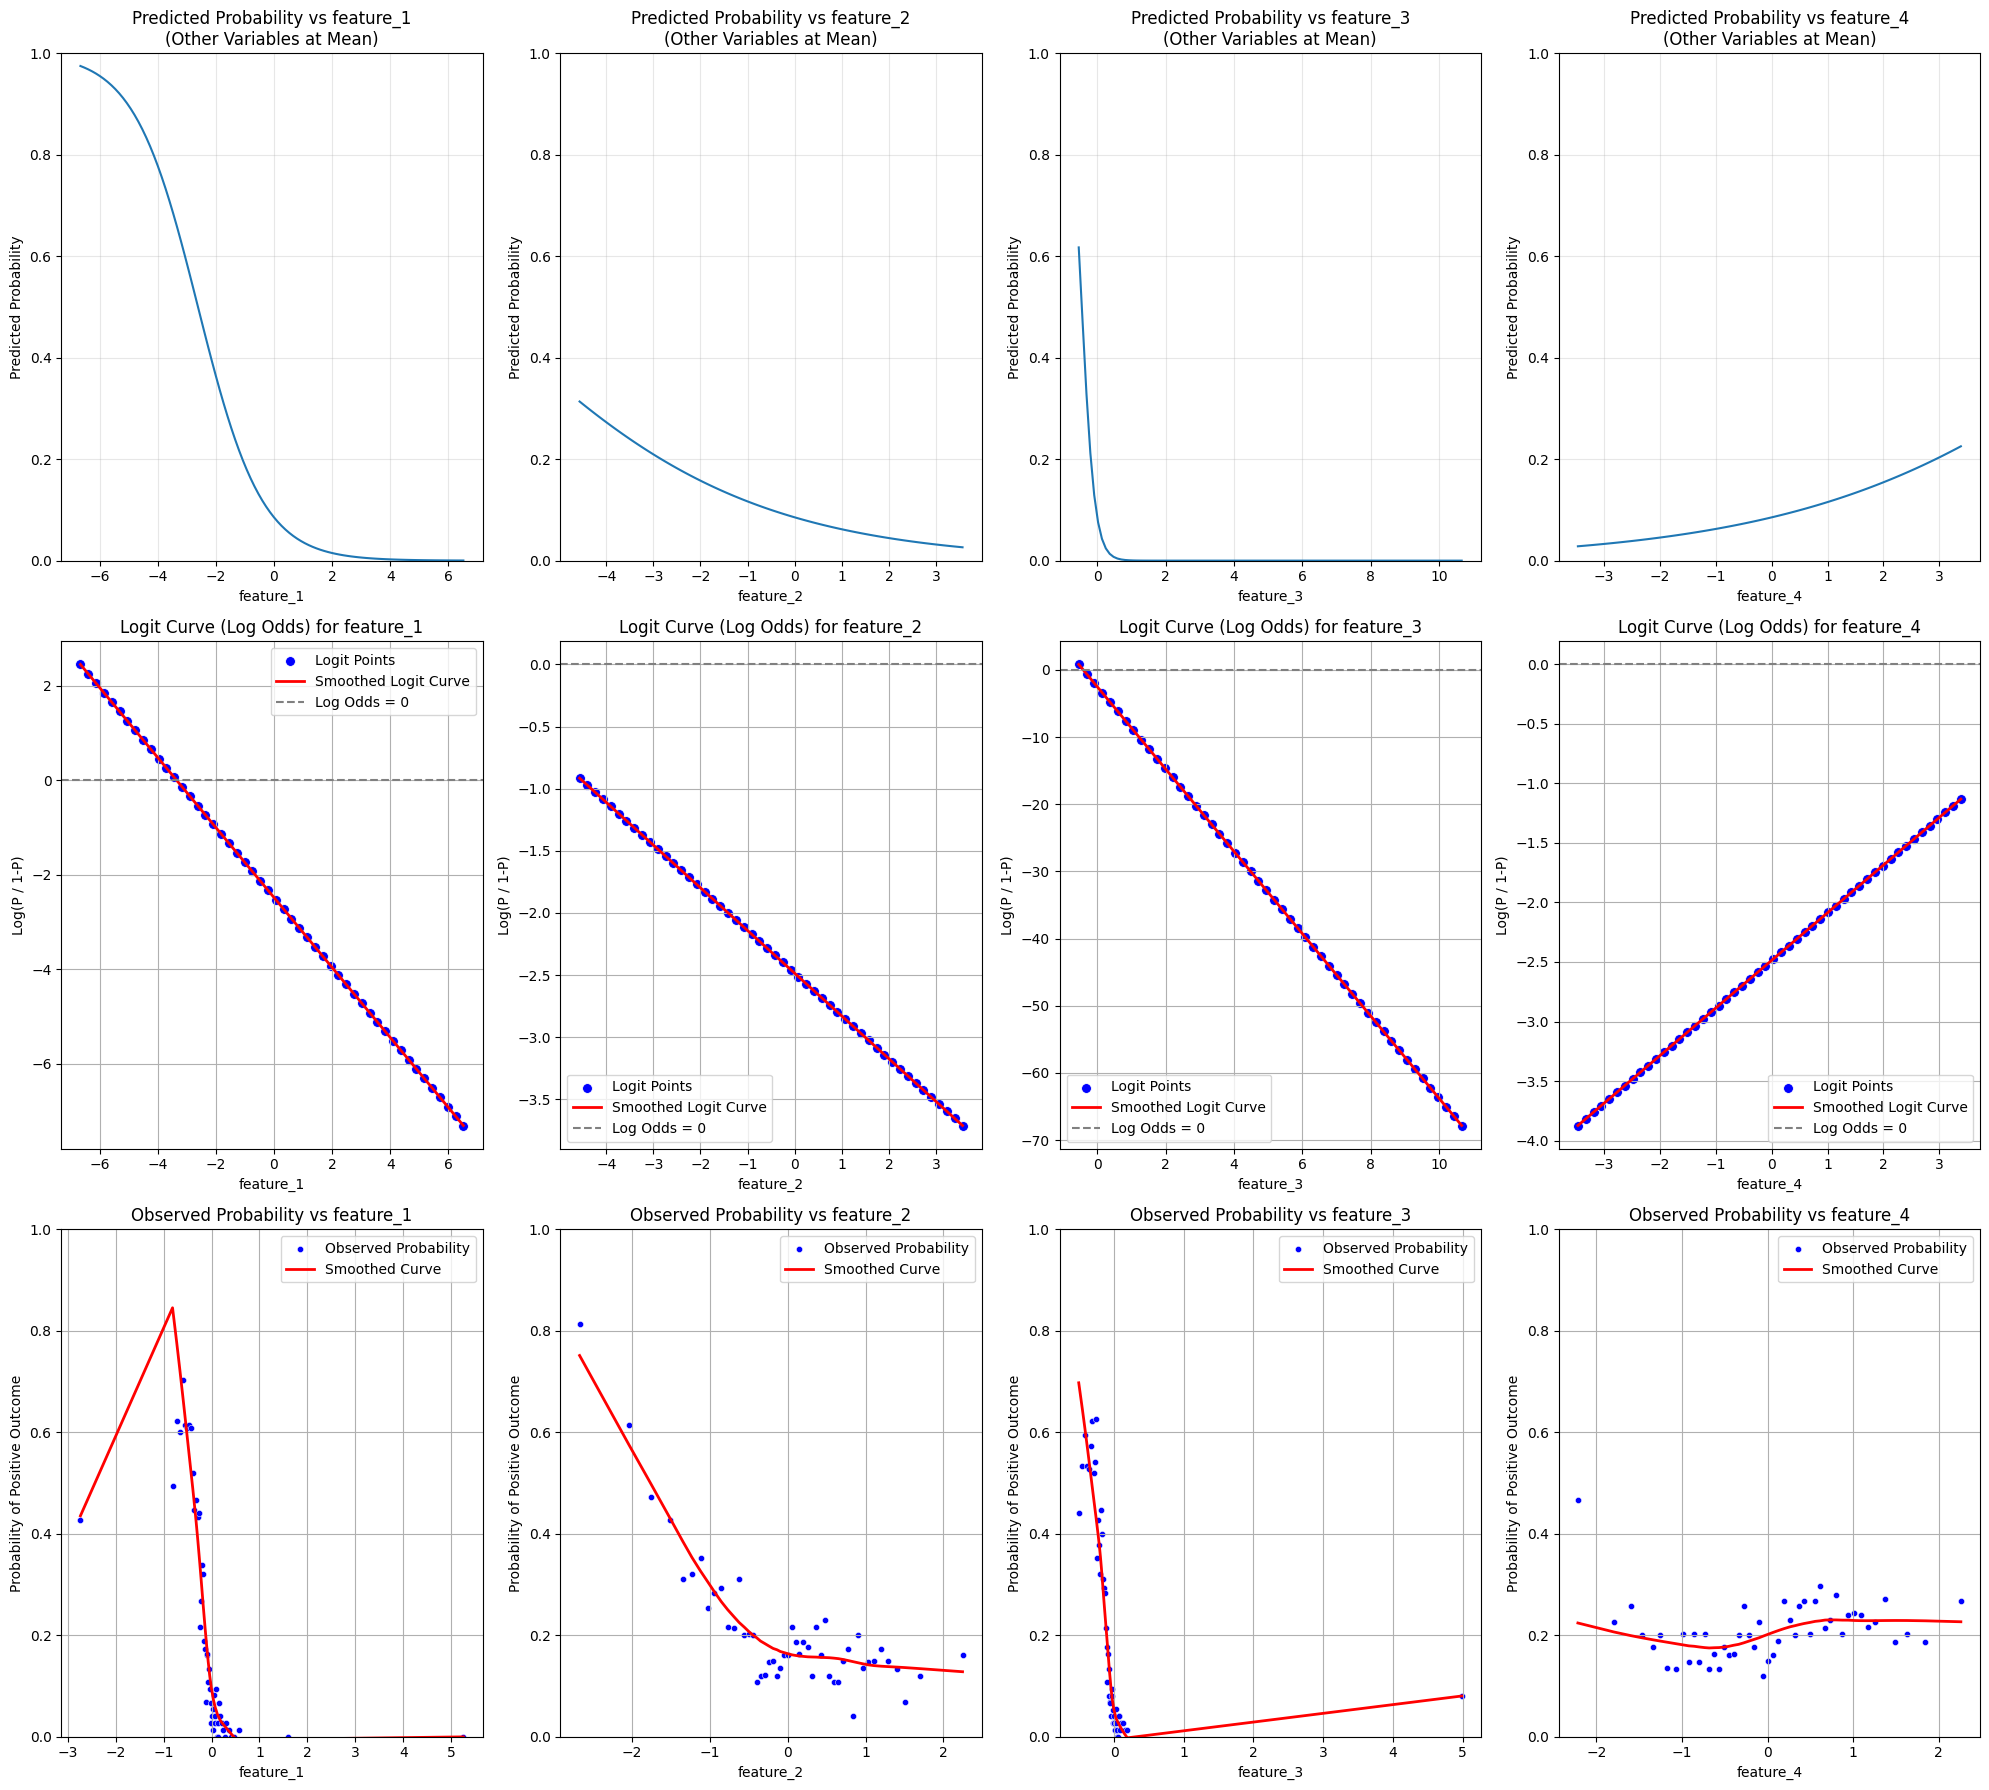

In [354]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm

X = train[['feature_1', 'feature_2', 'feature_3', 'feature_4']]
y = train['y']

lr_model = LogisticRegression(random_state=42)
lr_model.fit(X, y)

fig1, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12)) = plt.subplots(3, 4, figsize=(20, 18))

mean_values = X.mean()

for i, feature in enumerate(['feature_1', 'feature_2', 'feature_3', 'feature_4']):
    x_range = np.linspace(X[feature].min(), X[feature].max(), 100)
    
    pred_data = np.tile(mean_values, (100, 1))
    pred_data = pd.DataFrame(pred_data, columns=X.columns)
    pred_data[feature] = x_range
    
    y_pred = lr_model.predict_proba(pred_data)[:, 1]
    
    axes_top = [ax1, ax2, ax3, ax4]
    axes_top[i].plot(x_range, y_pred)
    axes_top[i].set_title(f'Predicted Probability vs {feature}\n(Other Variables at Mean)')
    axes_top[i].set_ylabel('Predicted Probability')
    axes_top[i].set_xlabel(feature)
    axes_top[i].grid(True, alpha=0.3)
    axes_top[i].set_ylim(0, 1)
    
    X_with_const = sm.add_constant(X)
    logit_model = sm.Logit(y, X_with_const)
    result = logit_model.fit()
    
    feature_values = np.linspace(X[feature].min(), X[feature].max(), 50)
    fixed_predictors = mean_values.copy()
    log_odds = []
    
    for value in feature_values:
        temp_predictors = fixed_predictors.copy()
        temp_predictors[feature] = value
        predictors_with_const = sm.add_constant(temp_predictors.values.reshape(1, -1), has_constant='add')
        logit = np.dot(predictors_with_const, result.params)
        log_odds.append(logit[0])
    
    plot_df = pd.DataFrame({
        feature: feature_values,
        'log_odds': log_odds
    })
    
    axes_middle = [ax5, ax6, ax7, ax8]
    sns.scatterplot(x=feature, y='log_odds', data=plot_df, color='blue', s=50, 
                    ax=axes_middle[i], label='Logit Points')
    sns.regplot(x=feature, y='log_odds', data=plot_df, scatter=False, lowess=True,
                color='red', line_kws={'lw': 2}, ax=axes_middle[i], label='Smoothed Logit Curve')
    
    axes_middle[i].set_title(f'Logit Curve (Log Odds) for {feature}')
    axes_middle[i].set_xlabel(feature)
    axes_middle[i].set_ylabel('Log(P / 1-P)')
    axes_middle[i].axhline(0, color='grey', linestyle='--', label='Log Odds = 0')
    axes_middle[i].legend()
    axes_middle[i].grid(True)
    
    bins = pd.qcut(X[feature], q=50, duplicates='drop')
    bin_means = X.groupby(bins)[feature].mean()
    bin_probs = train.groupby(bins)['y'].mean()
    
    axes_bottom = [ax9, ax10, ax11, ax12]
    sns.scatterplot(x=bin_means, y=bin_probs, ax=axes_bottom[i], color='blue', s=20, label='Observed Probability')
    sns.regplot(x=bin_means, y=bin_probs, scatter=False, lowess=True,
                color='red', line_kws={'lw': 2}, ax=axes_bottom[i], label='Smoothed Curve')
    
    axes_bottom[i].set_title(f'Observed Probability vs {feature}')
    axes_bottom[i].set_xlabel(feature)
    axes_bottom[i].set_ylabel('Probability of Positive Outcome')
    axes_bottom[i].set_ylim(0, 1)
    axes_bottom[i].legend()
    axes_bottom[i].grid(True)

plt.tight_layout()
plt.show()

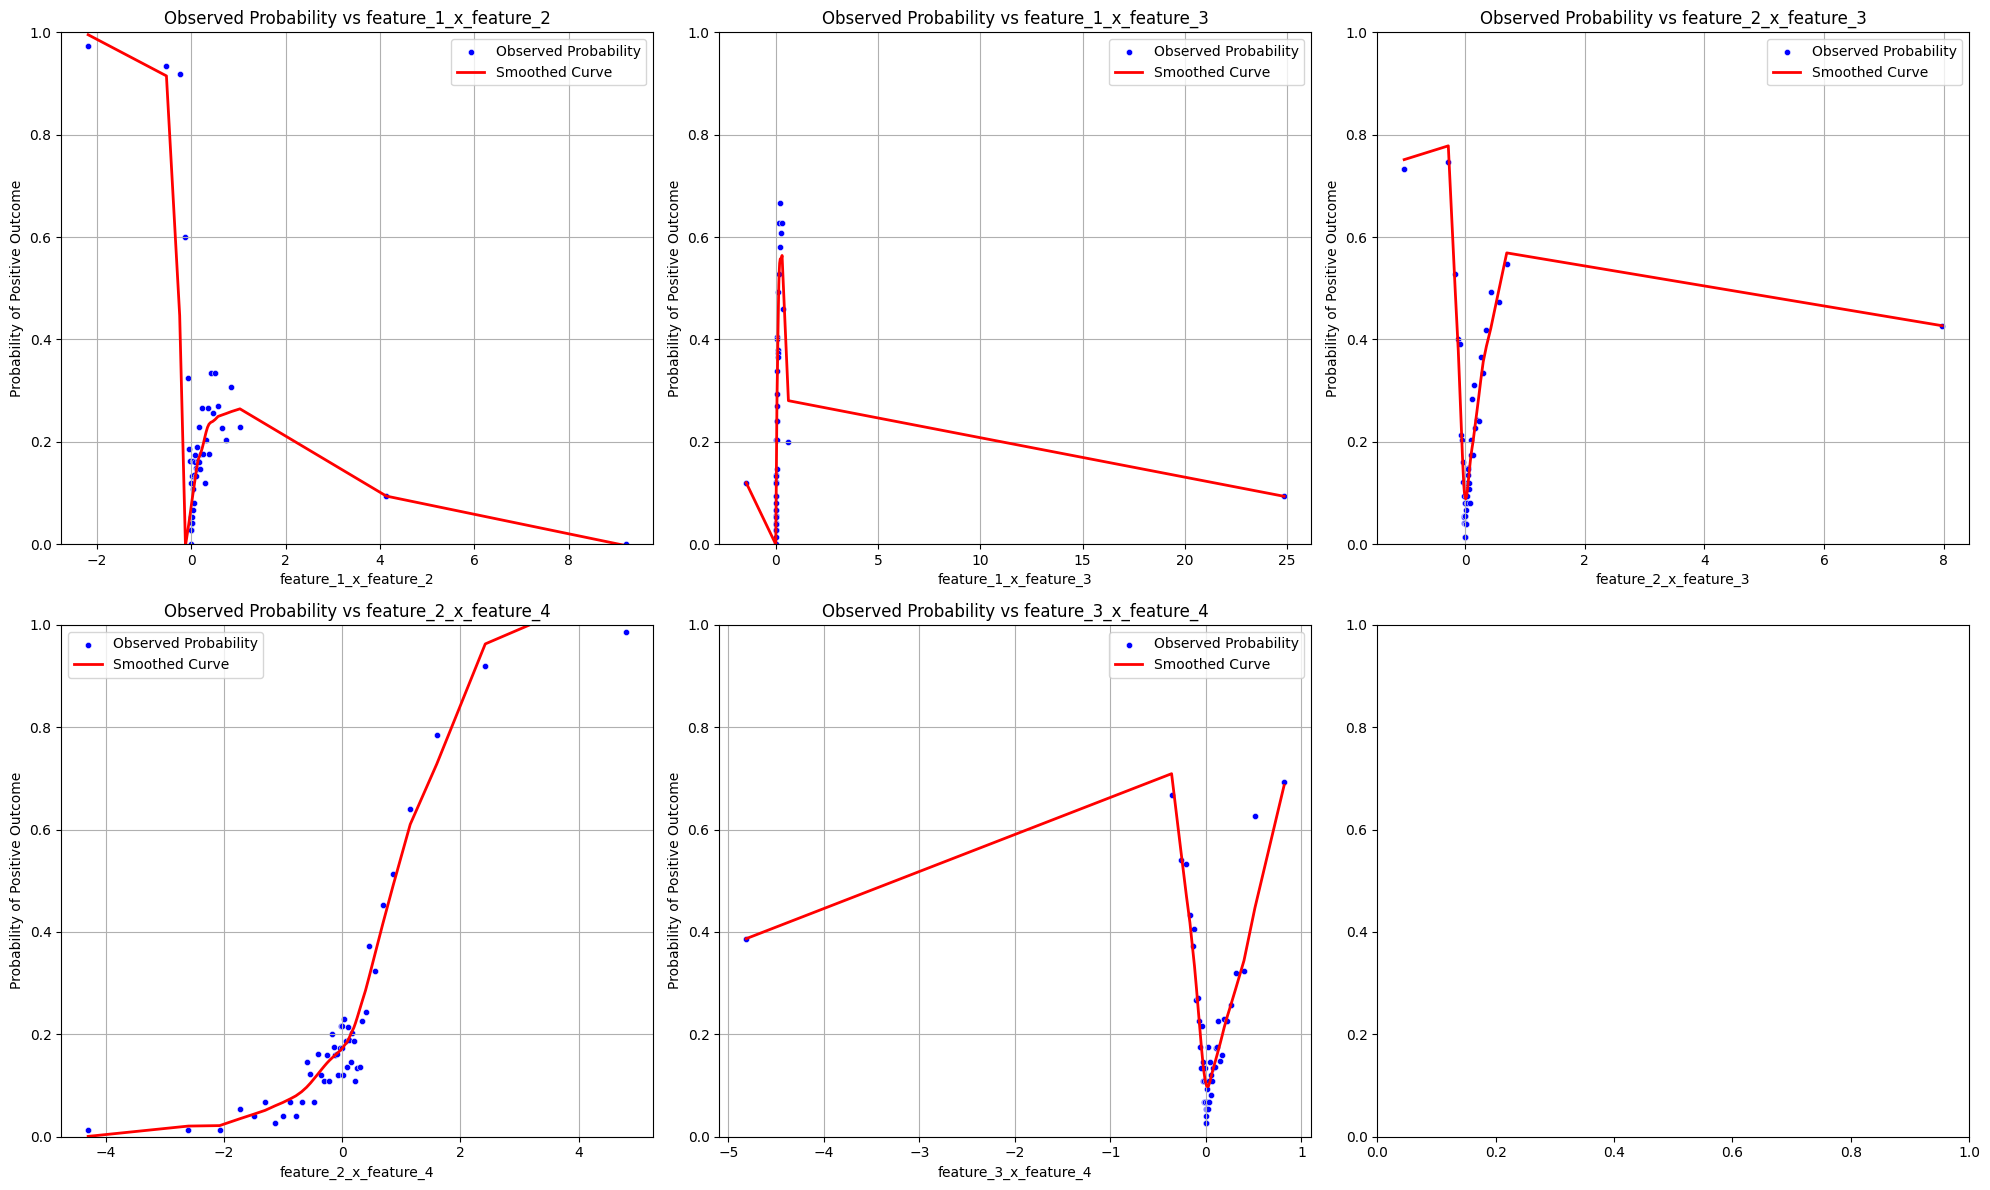

In [355]:
X = train[['feature_1', 'feature_2', 'feature_3', 'feature_4',
           'feature_1_x_feature_2', 'feature_1_x_feature_3', 
           'feature_2_x_feature_3', 'feature_2_x_feature_4',
           'feature_3_x_feature_4']]
y = train['y']

fig1, ((ax1, ax2, ax3), (ax4, ax5, _)) = plt.subplots(2, 3, figsize=(20, 12))
axes = [ax1, ax2, ax3, ax4, ax5]

interaction_terms = ['feature_1_x_feature_2', 'feature_1_x_feature_3', 
                    'feature_2_x_feature_3', 'feature_2_x_feature_4', 
                    'feature_3_x_feature_4']

for i, feature in enumerate(interaction_terms):
    bins = pd.qcut(X[feature], q=50, duplicates='drop')
    bin_means = X.groupby(bins)[feature].mean()
    bin_probs = train.groupby(bins)['y'].mean()
    
    sns.scatterplot(x=bin_means, y=bin_probs, ax=axes[i], color='blue', s=20, label='Observed Probability')
    sns.regplot(x=bin_means, y=bin_probs, scatter=False, lowess=True,
                color='red', line_kws={'lw': 2}, ax=axes[i], label='Smoothed Curve')
    
    axes[i].set_title(f'Observed Probability vs {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Probability of Positive Outcome')
    axes[i].set_ylim(0, 1)
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()


# Check for Multi-collinearity

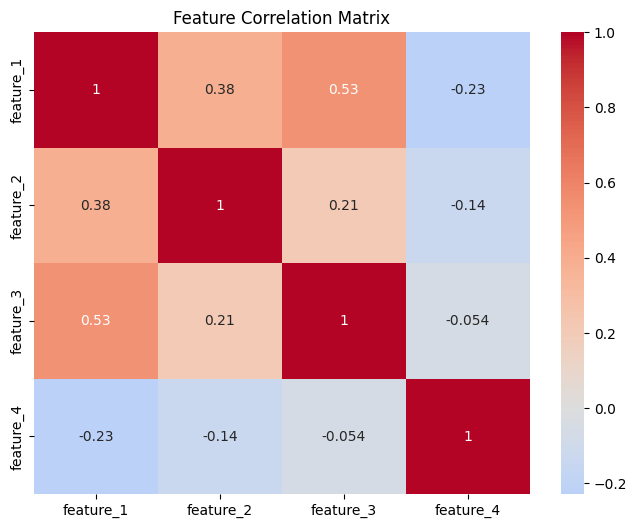

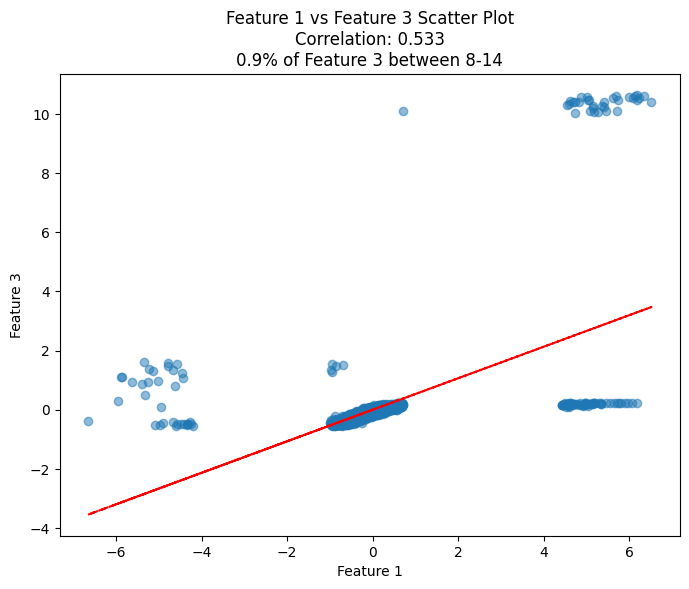

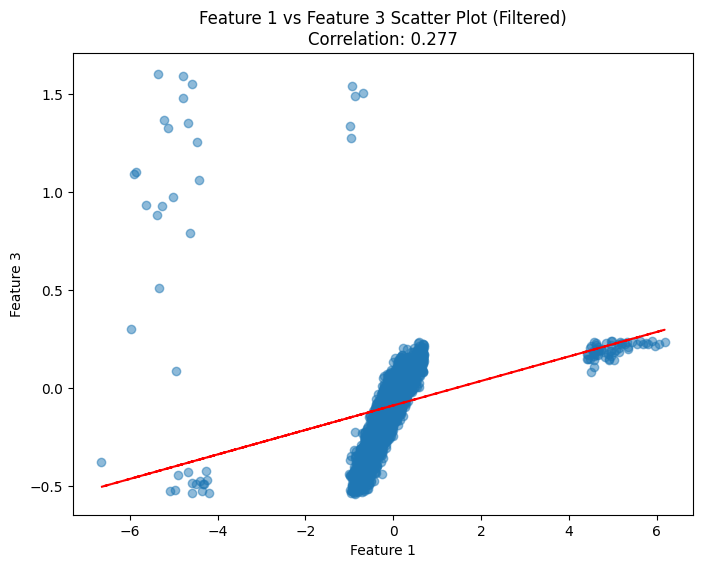

In [356]:
# Feature Correlation Matrix
correlation_matrix = train[['feature_1', 'feature_2', 'feature_3', 'feature_4']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()


plt.figure(figsize=(8, 6))
plt.scatter(train['feature_1'], train['feature_3'], alpha=0.5)
z = np.polyfit(train['feature_1'], train['feature_3'], 1)
p = np.poly1d(z)
plt.plot(train['feature_1'], p(train['feature_1']), "r--")
corr = train['feature_1'].corr(train['feature_3'])
pct_between = (train['feature_3'][(train['feature_3'] >= 8) & (train['feature_3'] <= 14)].count() / train['feature_3'].count()) * 100
plt.xlabel('Feature 1')
plt.ylabel('Feature 3')
plt.title(f'Feature 1 vs Feature 3 Scatter Plot\nCorrelation: {corr:.3f}\n{pct_between:.1f}% of Feature 3 between 8-14')
plt.show()

filtered_data = train[~((train['feature_3'] >= 8) & (train['feature_3'] <= 14))]
plt.figure(figsize=(8, 6))
plt.scatter(filtered_data['feature_1'], filtered_data['feature_3'], alpha=0.5)
z = np.polyfit(filtered_data['feature_1'], filtered_data['feature_3'], 1)
p = np.poly1d(z)
plt.plot(filtered_data['feature_1'], p(filtered_data['feature_1']), "r--")
corr = filtered_data['feature_1'].corr(filtered_data['feature_3'])
plt.xlabel('Feature 1')
plt.ylabel('Feature 3')
plt.title(f'Feature 1 vs Feature 3 Scatter Plot (Filtered)\nCorrelation: {corr:.3f}')
plt.show()


features 1 and 3 are not significantly correlated, those are just outliers. 

# Main drivers Visualizations 

## Features 1 and 3 

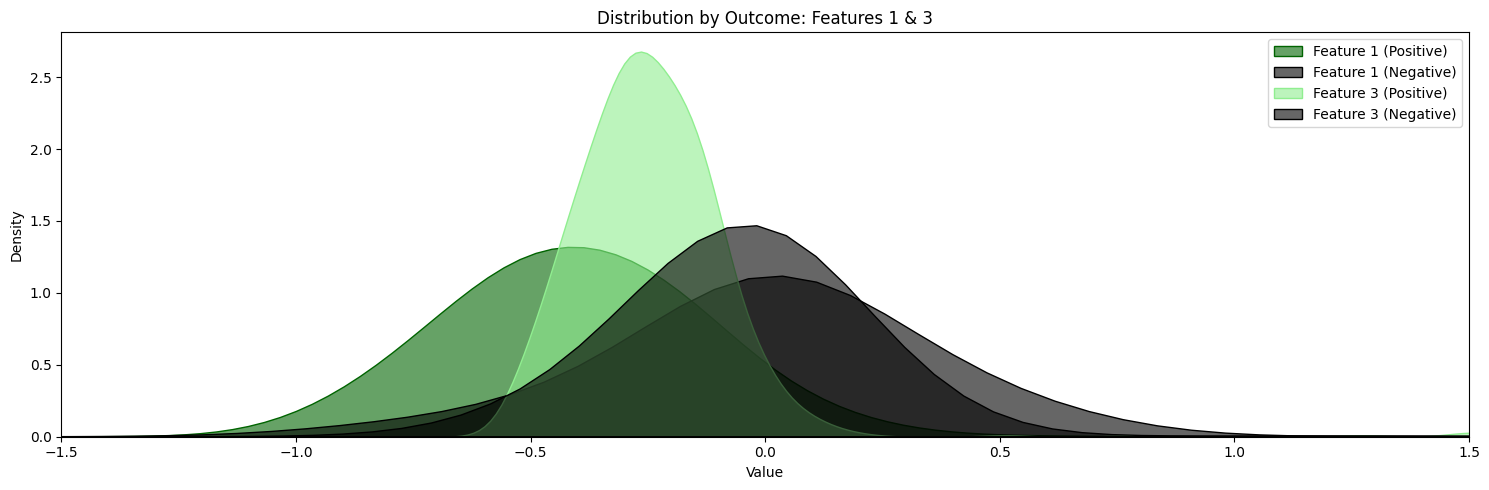

In [357]:
fig, ax = plt.subplots(figsize=(15, 5))

positive_data = train[train['y'] == 1]
negative_data = train[train['y'] == 0]

sns.kdeplot(data=positive_data['feature_1'], ax=ax, fill=True, alpha=0.6, label='Feature 1 (Positive)', color='darkgreen')
sns.kdeplot(data=negative_data['feature_1'], ax=ax, fill=True, alpha=0.6, label='Feature 1 (Negative)', color='black')
sns.kdeplot(data=positive_data['feature_3'], ax=ax, fill=True, alpha=0.6, label='Feature 3 (Positive)', color='lightgreen')
sns.kdeplot(data=negative_data['feature_3'], ax=ax, fill=True, alpha=0.6, label='Feature 3 (Negative)', color='black')
ax.set_title('Distribution by Outcome: Features 1 & 3')
ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.set_xlim(-1.5, 1.5)
ax.legend()

plt.tight_layout()
plt.show()


Significantly different means of the positive negative outcomes for features 1 and 3. 

## Features 2 and 4 

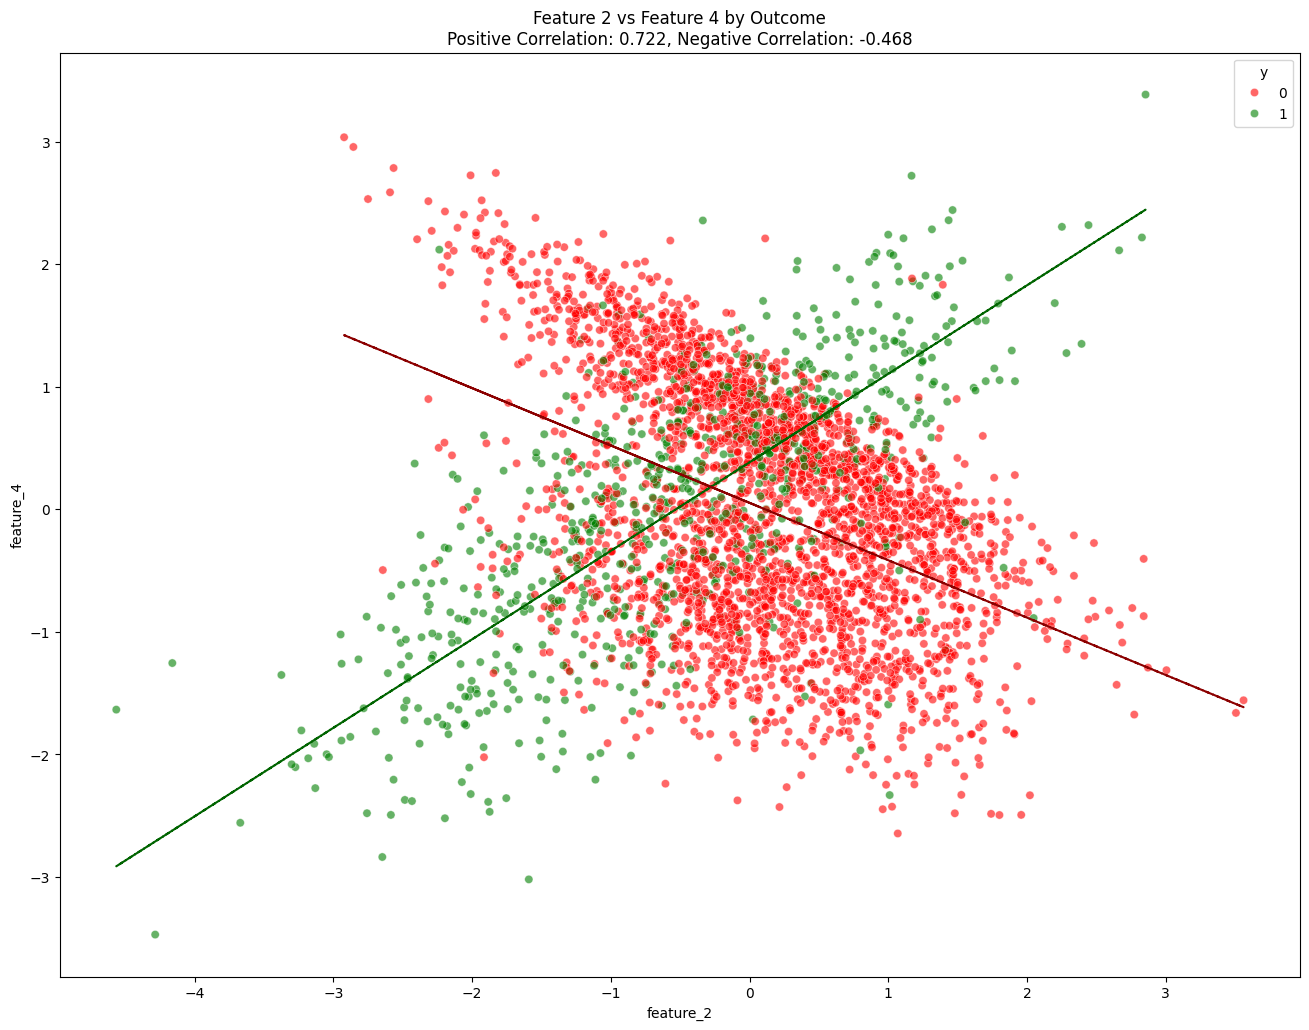

In [358]:
plt.figure(figsize=(16,12))

positive_data = train[train['y'] == 1]
negative_data = train[train['y'] == 0]

pos_corr = positive_data['feature_2'].corr(positive_data['feature_4'])
neg_corr = negative_data['feature_2'].corr(negative_data['feature_4'])

sns.scatterplot(data=train, x='feature_2', y='feature_4', hue='y',
                palette={1: 'green', 0: 'red'}, alpha=0.6)

x_pos = positive_data['feature_2']
y_pos = pos_corr * x_pos + (positive_data['feature_4'].mean() - pos_corr * positive_data['feature_2'].mean())
plt.plot(x_pos, y_pos, color='darkgreen', linestyle='--')

x_neg = negative_data['feature_2']
y_neg = neg_corr * x_neg + (negative_data['feature_4'].mean() - neg_corr * negative_data['feature_2'].mean())
plt.plot(x_neg, y_neg, color='darkred', linestyle='--')

plt.title(f'Feature 2 vs Feature 4 by Outcome\nPositive Correlation: {pos_corr:.3f}, Negative Correlation: {neg_corr:.3f}')
plt.show()

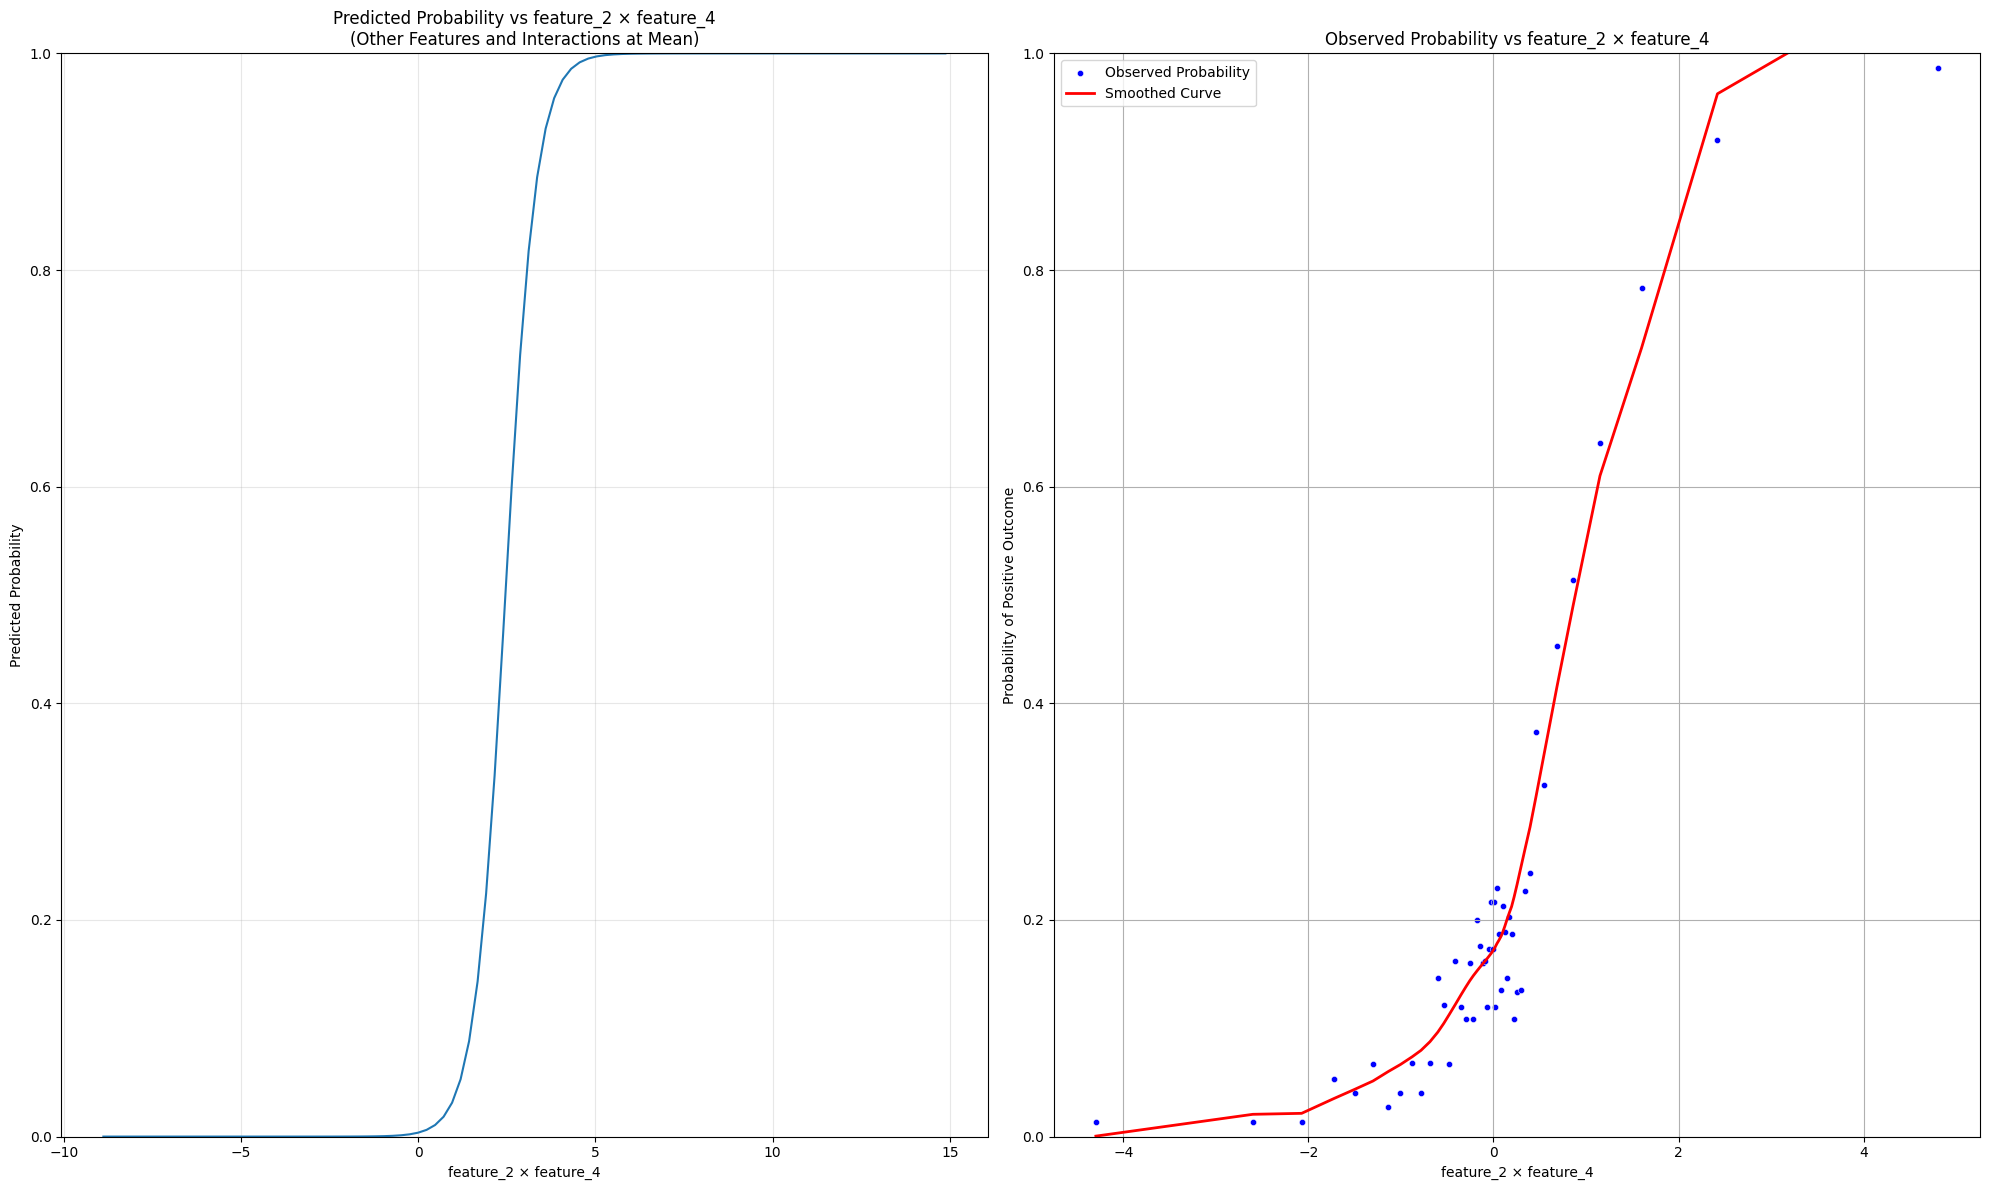

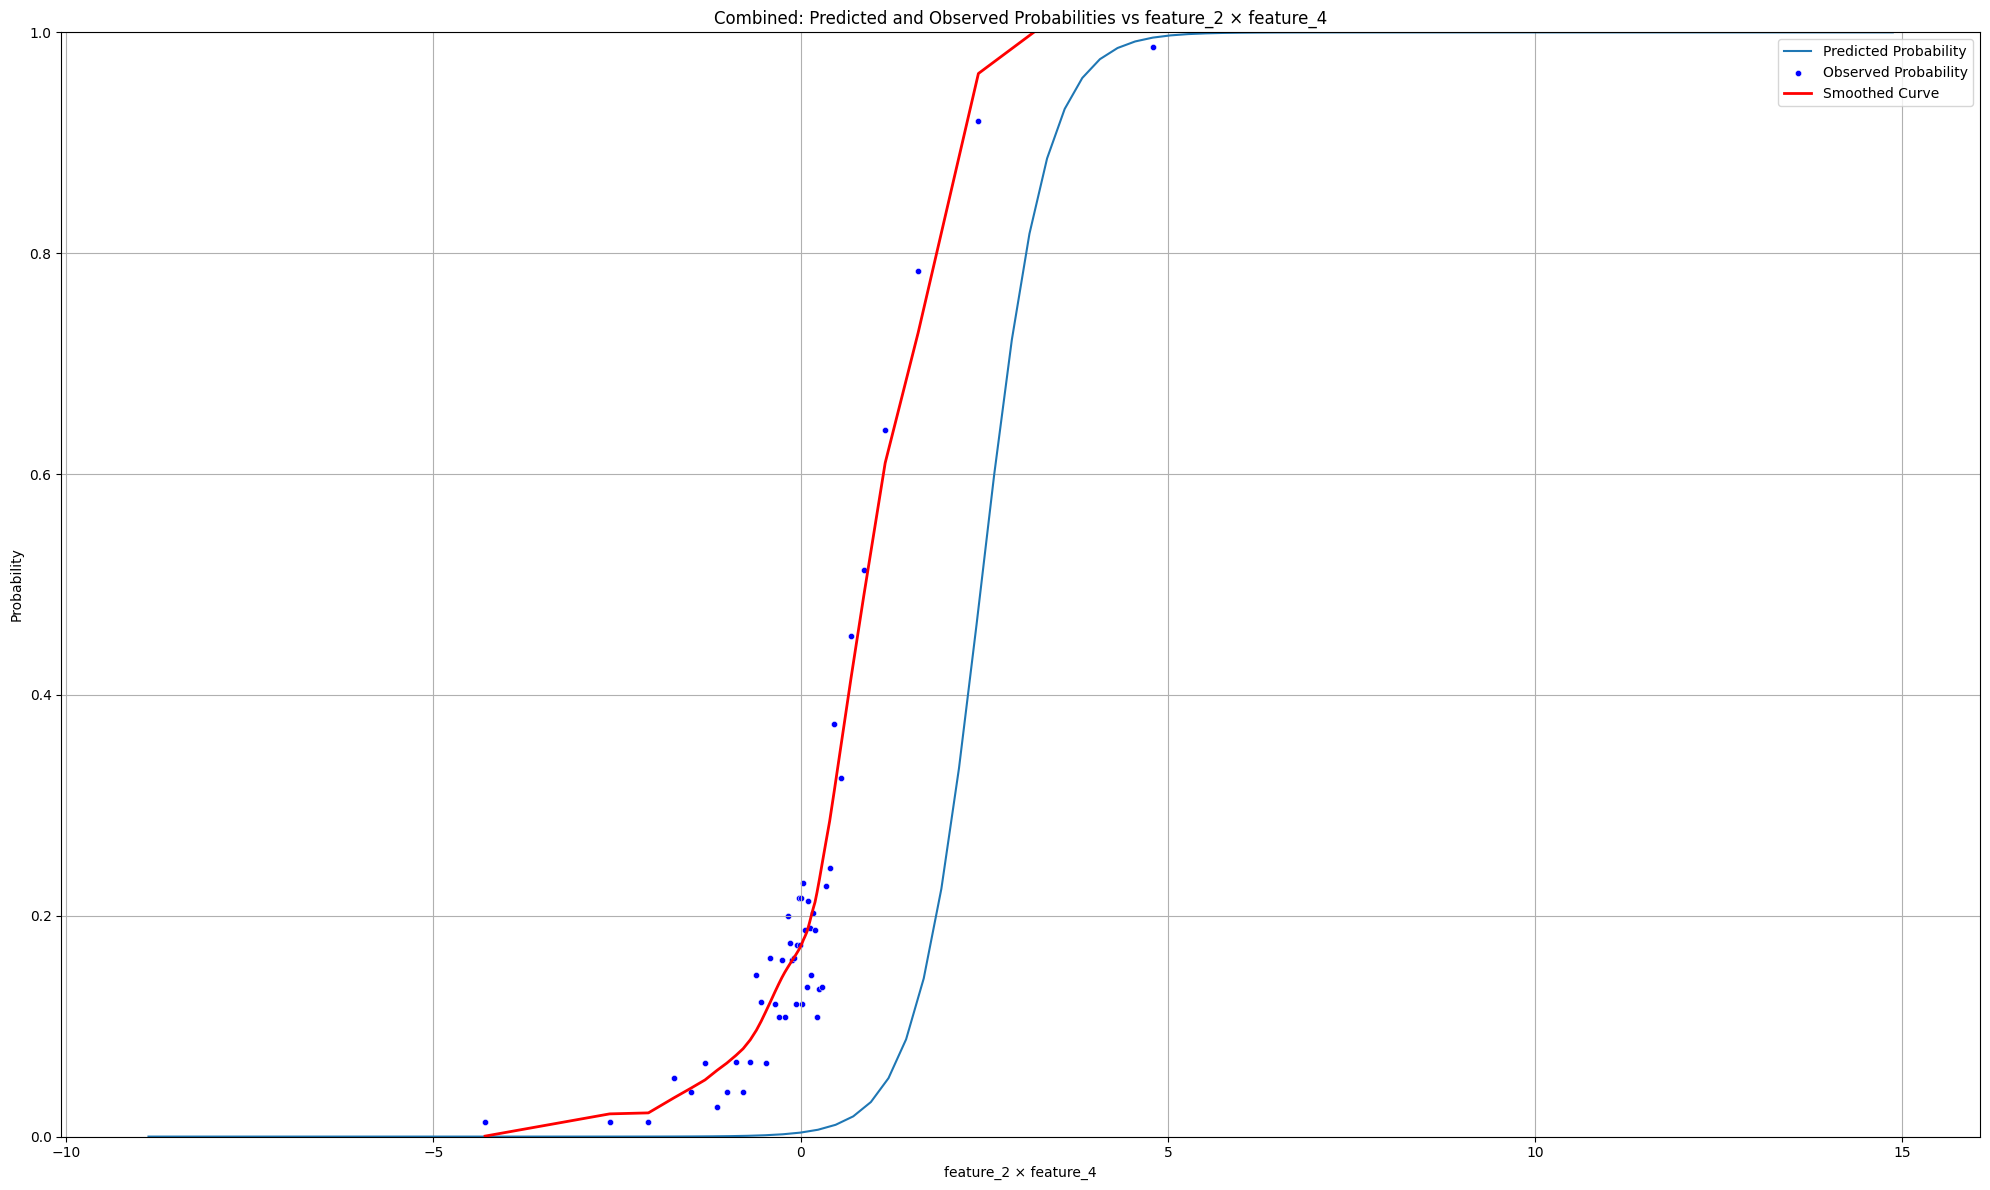

In [359]:
X = train[['feature_1', 'feature_2', 'feature_3', 'feature_4', 
           'feature_1_x_feature_2', 'feature_1_x_feature_3',
           'feature_2_x_feature_3', 'feature_2_x_feature_4', 'feature_3_x_feature_4']]
y = train['y']

lr_model = LogisticRegression(random_state=42)
lr_model.fit(X, y)

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))

mean_values = X.mean()
interaction_range = np.linspace(train['feature_2_x_feature_4'].min(), train['feature_2_x_feature_4'].max(), 100)

pred_data = np.tile(mean_values, (100, 1))
pred_data = pd.DataFrame(pred_data, columns=X.columns)
pred_data['feature_2_x_feature_4'] = interaction_range

y_pred = lr_model.predict_proba(pred_data)[:, 1]

ax1.plot(interaction_range, y_pred)
ax1.set_title('Predicted Probability vs feature_2 × feature_4\n(Other Features and Interactions at Mean)')
ax1.set_ylabel('Predicted Probability')
ax1.set_xlabel('feature_2 × feature_4')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)

bins = pd.qcut(X['feature_2_x_feature_4'], q=50, duplicates='drop')
bin_means = X.groupby(bins)['feature_2_x_feature_4'].mean()
bin_probs = train.groupby(bins)['y'].mean()

sns.scatterplot(x=bin_means, y=bin_probs, ax=ax2, color='blue', s=20, label='Observed Probability')
sns.regplot(x=bin_means, y=bin_probs, scatter=False, lowess=True,
            color='red', line_kws={'lw': 2}, ax=ax2, label='Smoothed Curve')

ax2.set_title('Observed Probability vs feature_2 × feature_4')
ax2.set_xlabel('feature_2 × feature_4')
ax2.set_ylabel('Probability of Positive Outcome')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

fig2, ax3 = plt.subplots(figsize=(20, 12))
ax3.plot(interaction_range, y_pred, label='Predicted Probability')
sns.scatterplot(x=bin_means, y=bin_probs, ax=ax3, color='blue', s=20, label='Observed Probability')
sns.regplot(x=bin_means, y=bin_probs, scatter=False, lowess=True,
            color='red', line_kws={'lw': 2}, ax=ax3, label='Smoothed Curve')

ax3.set_title('Combined: Predicted and Observed Probabilities vs feature_2 × feature_4')
ax3.set_xlabel('feature_2 × feature_4')
ax3.set_ylabel('Probability')
ax3.set_ylim(0, 1)
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()


thus the interaction term produced for features 2 and 4 had a highly predictive coefficient. 


This is not mutually exclusive with the trend of feature 2 being negatively associated with positive outcomes as when feature 2 and feature 4 are within this range of each other is where the positives are located, thus when we give features 2 and 4 their own interaction term which is highly associated with positive outcomes.

Optimization terminated successfully.
         Current function value: 0.365151
         Iterations 8


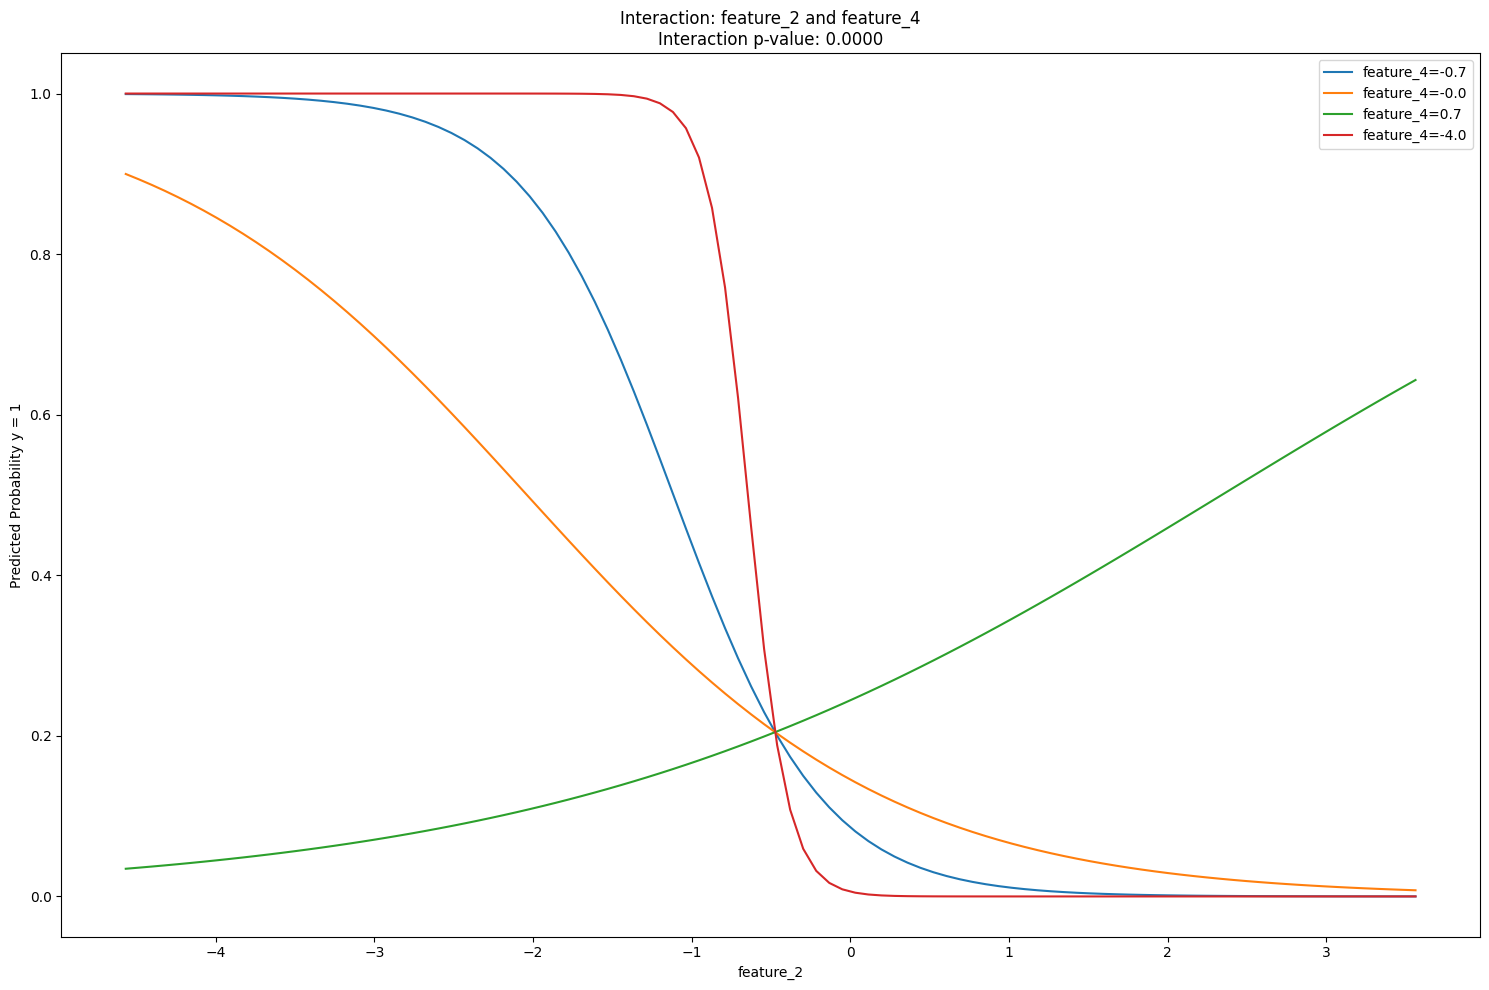


Significant interaction (p < 0.05):
feature_2 x feature_4


In [360]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 10))

formula = 'y ~ feature_2 * feature_4'
model = sm.Logit.from_formula(formula, data=train).fit()
interaction_pvalue = model.pvalues['feature_2:feature_4']

feature_2_values = np.linspace(train['feature_2'].min(), train['feature_2'].max(), 100)
feature_4_levels = list(np.percentile(train['feature_4'], [25, 50, 75])) + [-4]

for feature_4_level in feature_4_levels:
    df = pd.DataFrame({
        'feature_2': feature_2_values,
        'feature_4': feature_4_level
    })
    df['interaction'] = df['feature_2'] * df['feature_4']
    df['predicted_prob'] = model.predict(sm.add_constant(df))
    
    ax.plot(df['feature_2'], df['predicted_prob'], 
           label=f'feature_4={feature_4_level:.1f}')

ax.set_xlabel('feature_2')
ax.set_ylabel('Predicted Probability y = 1')
ax.legend()
ax.set_title(f'Interaction: feature_2 and feature_4\nInteraction p-value: {interaction_pvalue:.4f}')

plt.tight_layout()
plt.show()

if interaction_pvalue < 0.05:
    print("\nSignificant interaction (p < 0.05):")
    print("feature_2 x feature_4")

# Random Forest Model - slightly superior performance but still significant

Optimal threshold: 0.230
Confusion Matrix:
[[801  44]
 [ 12 202]]

Recall at optimal threshold: 0.944


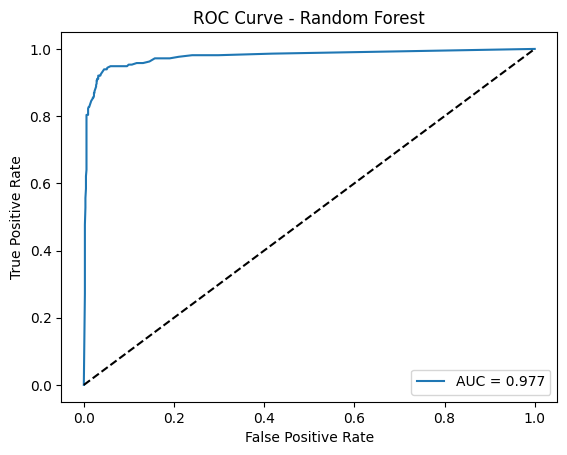

In [361]:
from sklearn.ensemble import RandomForestClassifier
X_train = train[['feature_1', 'feature_2', 'feature_3', 'feature_4']]
y_train = train['y']
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train);


from sklearn.metrics import roc_auc_score
X_test = test[['feature_1', 'feature_2', 'feature_3', 'feature_4']]
y_test = test['y']


rf_pred_proba = rf_model.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, rf_pred_proba)
auc_score = roc_auc_score(y_test, rf_pred_proba)


plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend();


fpr, tpr, thresholds = roc_curve(y_test, rf_pred_proba)
fnr = 1 - tpr
optimal_idx = np.argmin(np.abs(fpr - fnr))
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold: {optimal_threshold:.3f}")


y_pred = (rf_pred_proba >= optimal_threshold).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print(f"\nRecall at optimal threshold: {recall:.3f}")

# MORE EDA 

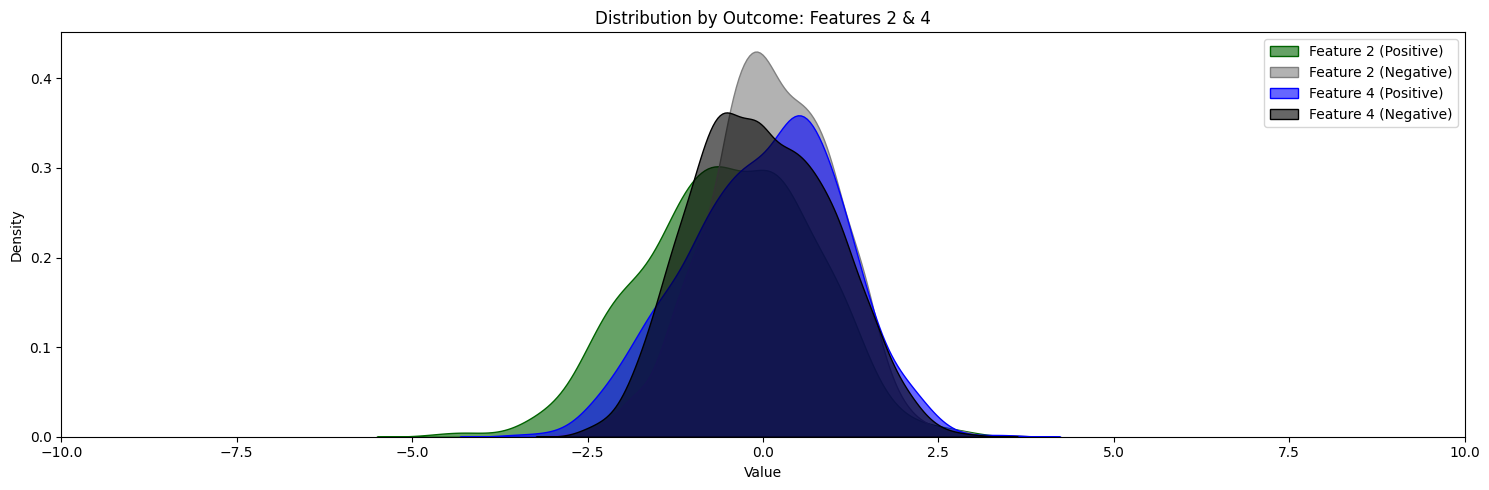

In [362]:
fig, ax = plt.subplots(figsize=(15, 5))

positive_data = train[train['y'] == 1]
negative_data = train[train['y'] == 0]

sns.kdeplot(data=positive_data['feature_2'], ax=ax, fill=True, alpha=0.6, label='Feature 2 (Positive)', color='darkgreen')
sns.kdeplot(data=negative_data['feature_2'], ax=ax, fill=True, alpha=0.6, label='Feature 2 (Negative)', color='grey')
sns.kdeplot(data=positive_data['feature_4'], ax=ax, fill=True, alpha=0.6, label='Feature 4 (Positive)', color='blue')
sns.kdeplot(data=negative_data['feature_4'], ax=ax, fill=True, alpha=0.6, label='Feature 4 (Negative)', color='black')
ax.set_title('Distribution by Outcome: Features 2 & 4')
ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.set_xlim(-10, 10)
ax.legend()

plt.tight_layout()
plt.show()
